In [1]:
import os
import pprint
import time
from pathlib import Path

import lightgbm as lgb
import numpy as np
import pandas as pd
import polars as pl
import scipy.sparse as sp
import seaborn as sns
import torch
from hydra import compose, initialize
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, _document_frequency
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.utils.validation import check_is_fitted
from src.groupkfold import GroupKFoldWithSeed
from src.seed import seed_everything
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from tqdm.auto import tqdm
from transformers import AutoModel, AutoTokenizer

with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


lgb:
  params_stage1:
    objective: regression
    metric: rmse
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.01
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 20
    bagging_fraction: 0.9
    bagging_freq: 1
    feature_fraction: 0.9
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  params_stage2:
    objective: binary
    metric: auc
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.01
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 20
    bagging_fraction: 0.9
    bagging_freq: 1
    feature_fraction: 0.9
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 500
  log_evaluation: 100
  num_boost_round: 10000000
exp_number: '009'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  cloth_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/009/base
seed: 42
n

### Import

In [2]:
train_df = pl.read_csv(cfg.data.train_path, try_parse_dates=True)
cloth_df = pl.read_csv(cfg.data.cloth_path, try_parse_dates=True)
test_df = pl.read_csv(cfg.data.test_path, try_parse_dates=True)

train_df = train_df.join(cloth_df, on="Clothing ID", how="left")
test_df = test_df.join(cloth_df, on="Clothing ID", how="left")
train_test_df = pl.concat([train_df, test_df], how="diagonal")

skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)

train_test_df.head()


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
i64,i64,str,str,i64,i64,i64,str,str,str
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts"""
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts"""
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts"""
0,45,null,"""I was really pleased with this…",5,1,9,"""General""","""Bottoms""","""Skirts"""
0,57,"""Unique, pretty asymmetric skir…","""I saw this skirt in retailer s…",5,1,1,"""General""","""Bottoms""","""Skirts"""


In [3]:
train_df["Rating"].value_counts()


Rating,count
i64,u32
2,671
4,2175
1,362
3,1240
5,5552


### 2Stage制を試してみる
- 1st Stage: Ratingを予測
- 2nd Stage: 1st Stageの予測結果を使ってRecommended INDを予測


### 特徴量作成

In [4]:
# 前処理(欠損をnoneという文字列で埋めておく)
train_test_df = train_test_df.with_columns(pl.col("Title").fill_null("none"), pl.col("Review Text").fill_null("none"))


In [6]:
# all text embをダウンロード(exp08)
all_text_embeddings_df = pl.read_parquet(os.path.join(cfg.data.data_root, "exp008_all_text_embeddings_by_e5.parquet"))

# embeddingsを次元削減
svd = TruncatedSVD(n_components=512, random_state=cfg.seed)
reduced_all_text_embs = svd.fit_transform(all_text_embeddings_df.to_numpy())

# 削減された特徴量をデータフレームに変換
reduced_all_text_emb_df = pl.DataFrame(reduced_all_text_embs).rename(
    {col: f"reduced_all_text_emb_{i}" for i, col in enumerate(pl.DataFrame(reduced_all_text_embs).columns)}
)

# train_test_dfに結合
train_test_df = pl.concat([train_test_df, reduced_all_text_emb_df], how="horizontal")

train_test_df.head()


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,reduced_all_text_emb_0,reduced_all_text_emb_1,reduced_all_text_emb_2,reduced_all_text_emb_3,reduced_all_text_emb_4,reduced_all_text_emb_5,reduced_all_text_emb_6,reduced_all_text_emb_7,reduced_all_text_emb_8,reduced_all_text_emb_9,reduced_all_text_emb_10,reduced_all_text_emb_11,reduced_all_text_emb_12,reduced_all_text_emb_13,reduced_all_text_emb_14,reduced_all_text_emb_15,reduced_all_text_emb_16,reduced_all_text_emb_17,reduced_all_text_emb_18,reduced_all_text_emb_19,reduced_all_text_emb_20,reduced_all_text_emb_21,reduced_all_text_emb_22,reduced_all_text_emb_23,reduced_all_text_emb_24,reduced_all_text_emb_25,reduced_all_text_emb_26,…,reduced_all_text_emb_475,reduced_all_text_emb_476,reduced_all_text_emb_477,reduced_all_text_emb_478,reduced_all_text_emb_479,reduced_all_text_emb_480,reduced_all_text_emb_481,reduced_all_text_emb_482,reduced_all_text_emb_483,reduced_all_text_emb_484,reduced_all_text_emb_485,reduced_all_text_emb_486,reduced_all_text_emb_487,reduced_all_text_emb_488,reduced_all_text_emb_489,reduced_all_text_emb_490,reduced_all_text_emb_491,reduced_all_text_emb_492,reduced_all_text_emb_493,reduced_all_text_emb_494,reduced_all_text_emb_495,reduced_all_text_emb_496,reduced_all_text_emb_497,reduced_all_text_emb_498,reduced_all_text_emb_499,reduced_all_text_emb_500,reduced_all_text_emb_501,reduced_all_text_emb_502,reduced_all_text_emb_503,reduced_all_text_emb_504,reduced_all_text_emb_505,reduced_all_text_emb_506,reduced_all_text_emb_507,reduced_all_text_emb_508,reduced_all_text_emb_509,reduced_all_text_emb_510,reduced_all_text_emb_511
i64,i64,str,str,i64,i64,i64,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts""",26.522205,-0.499324,-0.102274,-1.55513,0.869824,-1.156852,2.045372,-0.030957,0.320871,1.766019,-1.401759,-2.148114,1.176195,1.327037,0.223312,1.221828,1.324264,-1.243896,-0.70261,1.543136,1.635255,1.989471,-0.167773,-0.67867,-0.015937,-1.385899,0.004975,…,0.054011,0.055716,0.00891,-0.037202,-0.234164,0.112293,-0.053963,0.087851,0.141335,0.283426,0.063896,0.141194,0.047716,0.046274,-0.16575,0.208334,-0.30399,0.033065,0.247659,-0.23262,-0.021821,0.030293,-0.016559,-0.111486,0.215233,0.100948,-0.248074,0.047428,0.197025,-0.03826,-0.065567,0.131338,0.192207,0.107194,0.001568,0.076724,-0.021746
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts""",26.843914,-1.596456,0.34895,-1.399416,1.171347,-0.785103,0.301607,0.82724,-0.255405,1.431133,-1.332052,-2.363701,0.536325,0.969039,0.678487,1.332153,0.273209,-0.506366,0.01759,1.405149,1.127391,1.450834,-0.620589,0.063502,1.177327,0.110791,-0.385144,…,0.204937,0.226068,-0.351312,0.163872,-0.205886,0.30765,-0.002483,-0.060562,-0.345478,0.204922,0.170013,0.023841,-0.00241,0.085282,-0.370008,-0.003815,0.037519,-0.014204,-0.132769,0.0729,0.119152,0.142421,0.147531,-0.093987,-0.09377,0.064422,-0.282884,0.012474,-0.079671,-0.150943,0.098584,0.076702,-0.025803,0.11813,0.114473,-0.232086,0.003716
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts""",26.107113,-4.840739,-0.388405,-0.416746,1.23232,-1.355859,-0.410883,1.007644,1.014009,-0.584446,-0.818986,-2.103865,1.836963,1.649405,-0.054254,0.493439,0.911151,0.250545,0.897043,0.825975,0.098073,1.374016,-0.216026,2.126887,-0.444329,-0.059024,0.24937,…,-0.141819,-0.240411,-0.147747,0.162708,-0.080092,0.015134,-0.123363,0.078831,-0.0024,0.027845,0.07969,-0.112715,0.065764,-0.259428,0.052566,-0.012153,-0.069381,-0.038395,-0.029649,0.143277,-0.06387,0.435724,-0.083178,-0.059937,0

In [7]:
# Title, Review Textのembeddingsも次元削減してから結合(exp007)
text_embeddings_df = pl.read_parquet(os.path.join(cfg.data.data_root, "exp007_text_embeddings_by_e5.parquet"))

# 次元削減
svd = TruncatedSVD(n_components=512, random_state=cfg.seed)
reduced_text_embeddings = svd.fit_transform(text_embeddings_df.to_numpy())

# 削減された特徴量をデータフレームに変換
reduced_text_embeddings_df = pl.DataFrame(reduced_text_embeddings).rename(
    {col: f"reduced_text_emb_{i}" for i, col in enumerate(pl.DataFrame(reduced_text_embeddings).columns)}
)

# 結合
train_test_df = pl.concat([train_test_df, reduced_text_embeddings_df], how="horizontal")

train_test_df.head()


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,reduced_all_text_emb_0,reduced_all_text_emb_1,reduced_all_text_emb_2,reduced_all_text_emb_3,reduced_all_text_emb_4,reduced_all_text_emb_5,reduced_all_text_emb_6,reduced_all_text_emb_7,reduced_all_text_emb_8,reduced_all_text_emb_9,reduced_all_text_emb_10,reduced_all_text_emb_11,reduced_all_text_emb_12,reduced_all_text_emb_13,reduced_all_text_emb_14,reduced_all_text_emb_15,reduced_all_text_emb_16,reduced_all_text_emb_17,reduced_all_text_emb_18,reduced_all_text_emb_19,reduced_all_text_emb_20,reduced_all_text_emb_21,reduced_all_text_emb_22,reduced_all_text_emb_23,reduced_all_text_emb_24,reduced_all_text_emb_25,reduced_all_text_emb_26,…,reduced_text_emb_475,reduced_text_emb_476,reduced_text_emb_477,reduced_text_emb_478,reduced_text_emb_479,reduced_text_emb_480,reduced_text_emb_481,reduced_text_emb_482,reduced_text_emb_483,reduced_text_emb_484,reduced_text_emb_485,reduced_text_emb_486,reduced_text_emb_487,reduced_text_emb_488,reduced_text_emb_489,reduced_text_emb_490,reduced_text_emb_491,reduced_text_emb_492,reduced_text_emb_493,reduced_text_emb_494,reduced_text_emb_495,reduced_text_emb_496,reduced_text_emb_497,reduced_text_emb_498,reduced_text_emb_499,reduced_text_emb_500,reduced_text_emb_501,reduced_text_emb_502,reduced_text_emb_503,reduced_text_emb_504,reduced_text_emb_505,reduced_text_emb_506,reduced_text_emb_507,reduced_text_emb_508,reduced_text_emb_509,reduced_text_emb_510,reduced_text_emb_511
i64,i64,str,str,i64,i64,i64,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts""",26.522205,-0.499324,-0.102274,-1.55513,0.869824,-1.156852,2.045372,-0.030957,0.320871,1.766019,-1.401759,-2.148114,1.176195,1.327037,0.223312,1.221828,1.324264,-1.243896,-0.70261,1.543136,1.635255,1.989471,-0.167773,-0.67867,-0.015937,-1.385899,0.004975,…,-0.132744,0.23976,-0.151917,0.163951,0.140342,0.115068,-0.085293,0.167157,-0.090791,-0.403778,-0.138078,-0.14458,-0.15916,0.220765,-0.011697,-0.179144,-0.179937,-0.148103,0.401461,0.012824,-0.061743,-0.182151,0.035093,0.277038,-0.217977,-0.093588,-0.174415,0.270858,-0.091456,-0.011145,0.084504,-0.0267,-0.061238,0.188589,0.115129,0.089589,-0.031251
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts""",26.843914,-1.596456,0.34895,-1.399416,1.171347,-0.785103,0.301607,0.82724,-0.255405,1.431133,-1.332052,-2.363701,0.536325,0.969039,0.678487,1.332153,0.273209,-0.506366,0.01759,1.405149,1.127391,1.450834,-0.620589,0.063502,1.177327,0.110791,-0.385144,…,0.480606,0.083988,0.184964,0.249178,-0.394956,-0.136688,0.597457,-0.043768,-0.008037,-0.253152,0.07187,0.381424,0.141412,0.166879,0.232934,-0.214996,-0.106613,-0.192169,0.060468,-0.134362,-0.174851,-0.07193,-0.131245,0.051111,0.301647,0.125488,0.006745,-0.083829,0.062786,-0.07597,0.160694,-0.046053,0.323432,-0.105647,-0.072684,0.067054,0.037236
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts""",26.107113,-4.840739,-0.388405,-0.416746,1.23232,-1.355859,-0.410883,1.007644,1.014009,-0.584446,-0.818986,-2.103865,1.836963,1.649405,-0.054254,0.493439,0.911151,0.250545,0.897043,0.825975,0.098073,1.374016,-0.216026,2.126887,-0.444329,-0.059024,0.24937,…,-0.135574,-0.11273,0.271668,0.093014,-0.09974,0.006476,0.075997,0.26862,0.087232,-0.213214,-0.229018,-0.074103,-0.068614,-0.181115,-0.144289,-0.003542,-0.110377,-0.114113,0.267587,0.078726,-0.002432,-0.048487,-0.090829,0.203876,-0.044521,-0.261795,0.186919,-0.023657,-0.251433,-0.038075,-0.018669,-0.075578,-0.037222,0.366839,-0.318652,-0.078768,-0.092716
0,45,"""

In [8]:
# テキストデータ由来の特徴量

# CountVectorizer + 次元削減, TfidfVectorizer + 次元削減の結果をダウンロード
count_tfidf_dim_reduction_df = pl.read_parquet(
    os.path.join(cfg.data.data_root, "exp007_count_tfidf_dim_reduction.parquet")
)

# train_test_dfに結合
train_test_df = pl.concat([train_test_df, count_tfidf_dim_reduction_df], how="horizontal")

train_test_df.head()


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,reduced_all_text_emb_0,reduced_all_text_emb_1,reduced_all_text_emb_2,reduced_all_text_emb_3,reduced_all_text_emb_4,reduced_all_text_emb_5,reduced_all_text_emb_6,reduced_all_text_emb_7,reduced_all_text_emb_8,reduced_all_text_emb_9,reduced_all_text_emb_10,reduced_all_text_emb_11,reduced_all_text_emb_12,reduced_all_text_emb_13,reduced_all_text_emb_14,reduced_all_text_emb_15,reduced_all_text_emb_16,reduced_all_text_emb_17,reduced_all_text_emb_18,reduced_all_text_emb_19,reduced_all_text_emb_20,reduced_all_text_emb_21,reduced_all_text_emb_22,reduced_all_text_emb_23,reduced_all_text_emb_24,reduced_all_text_emb_25,reduced_all_text_emb_26,…,review_text_tfidf_lda_13,review_text_tfidf_lda_14,review_text_tfidf_lda_15,review_text_tfidf_lda_16,review_text_tfidf_lda_17,review_text_tfidf_lda_18,review_text_tfidf_lda_19,review_text_tfidf_lda_20,review_text_tfidf_lda_21,review_text_tfidf_lda_22,review_text_tfidf_lda_23,review_text_tfidf_lda_24,review_text_tfidf_lda_25,review_text_tfidf_lda_26,review_text_tfidf_lda_27,review_text_tfidf_lda_28,review_text_tfidf_lda_29,review_text_tfidf_lda_30,review_text_tfidf_lda_31,review_text_tfidf_lda_32,review_text_tfidf_lda_33,review_text_tfidf_lda_34,review_text_tfidf_lda_35,review_text_tfidf_lda_36,review_text_tfidf_lda_37,review_text_tfidf_lda_38,review_text_tfidf_lda_39,review_text_tfidf_lda_40,review_text_tfidf_lda_41,review_text_tfidf_lda_42,review_text_tfidf_lda_43,review_text_tfidf_lda_44,review_text_tfidf_lda_45,review_text_tfidf_lda_46,review_text_tfidf_lda_47,review_text_tfidf_lda_48,review_text_tfidf_lda_49
i64,i64,str,str,i64,i64,i64,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts""",26.522205,-0.499324,-0.102274,-1.55513,0.869824,-1.156852,2.045372,-0.030957,0.320871,1.766019,-1.401759,-2.148114,1.176195,1.327037,0.223312,1.221828,1.324264,-1.243896,-0.70261,1.543136,1.635255,1.989471,-0.167773,-0.67867,-0.015937,-1.385899,0.004975,…,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.839511,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts""",26.843914,-1.596456,0.34895,-1.399416,1.171347,-0.785103,0.301607,0.82724,-0.255405,1.431133,-1.332052,-2.363701,0.536325,0.969039,0.678487,1.332153,0.273209,-0.506366,0.01759,1.405149,1.127391,1.450834,-0.620589,0.063502,1.177327,0.110791,-0.385144,…,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.741221,0.002717,0.002717,0.002717,0.002717,0.036691,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.094366,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts""",26.107113,-4.840739,-0.388405,-0.416746,1.23232,-1.355859,-0.410883,1.007644,1.014009,-0.584446,-0.818986,-2.103865,1.836963,1.649405,-0.054254,0.493439,0.911151,0.250545,0.897043,0.825975,0.098073,1.374016,-0.216026,2.126887,-0.444329,-0.059024,0.24937,…,0.002375,0.029709,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.792022,0.002375,0.002375,0.031642,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.00

In [9]:
# BM25を実装
# reference: https://github.com/arosh/BM25Transformer/blob/master/bm25.py
class BM25Transformer(BaseEstimator, TransformerMixin):
    """
    Parameters
    ----------
    use_idf : boolean, optional (default=True)
    k1 : float, optional (default=2.0)
    b : float, optional (default=0.75)
    References
    ----------
    Okapi BM25: a non-binary model - Introduction to Information Retrieval
    http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html
    """

    def __init__(self, use_idf=True, k1=2.0, b=0.75):
        self.use_idf = use_idf
        self.k1 = k1
        self.b = b

    def fit(self, X):
        """
        Parameters
        ----------
        X : sparse matrix, [n_samples, n_features]
            document-term matrix
        """
        if not sp.issparse(X):
            X = sp.csc_matrix(X)
        if self.use_idf:
            n_samples, n_features = X.shape
            df = _document_frequency(X)
            idf = np.log((n_samples - df + 0.5) / (df + 0.5))
            self._idf_diag = sp.spdiags(idf, diags=0, m=n_features, n=n_features)
        return self

    def transform(self, X, copy=True):
        """
        Parameters
        ----------
        X : sparse matrix, [n_samples, n_features]
            document-term matrix
        copy : boolean, optional (default=True)
        """
        if hasattr(X, "dtype") and np.issubdtype(X.dtype, np.floating):
            # preserve float family dtype
            X = sp.csr_matrix(X, copy=copy)
        else:
            # convert counts or binary occurrences to floats
            X = sp.csr_matrix(X, dtype=np.float64, copy=copy)

        n_samples, n_features = X.shape

        # Document length (number of terms) in each row
        # Shape is (n_samples, 1)
        dl = X.sum(axis=1)
        # Number of non-zero elements in each row
        # Shape is (n_samples, )
        sz = X.indptr[1:] - X.indptr[0:-1]
        # In each row, repeat `dl` for `sz` times
        # Shape is (sum(sz), )
        # Example
        # -------
        # dl = [4, 5, 6]
        # sz = [1, 2, 3]
        # rep = [4, 5, 5, 6, 6, 6]
        rep = np.repeat(np.asarray(dl), sz)
        # Average document length
        # Scalar value
        avgdl = np.average(dl)
        # Compute BM25 score only for non-zero elements
        data = X.data * (self.k1 + 1) / (X.data + self.k1 * (1 - self.b + self.b * rep / avgdl))
        X = sp.csr_matrix((data, X.indices, X.indptr), shape=X.shape)

        if self.use_idf:
            check_is_fitted(self, "_idf_diag")

            expected_n_features = self._idf_diag.shape[0]
            if n_features != expected_n_features:
                raise ValueError(
                    "Input has n_features=%d while the model"
                    " has been trained with n_features=%d" % (n_features, expected_n_features)
                )
            # *= doesn't work
            X = X * self._idf_diag

        return X


# bm25は負の値をとりうるため、TruncatedSVDでのみ次元削減を行う
bm25_svd = Pipeline(
    steps=[
        ("CountVectorizer", CountVectorizer()),
        ("BM25Transformer", BM25Transformer()),
        ("TruncatedSVD", TruncatedSVD(n_components=50, random_state=cfg.seed)),
    ]
)


title_features_bm25_svd = bm25_svd.fit_transform(train_test_df["Title"].fill_null(""))

review_text_features_bm25_svd = bm25_svd.fit_transform(train_test_df["Review Text"].fill_null(""))


In [10]:
# 特徴量をデータフレームに変換してtrain_test_dfに結合

title_features_bm25_svd_df = pl.DataFrame(title_features_bm25_svd).rename(
    {col: f"title_bm25_svd_{i}" for i, col in enumerate(pl.DataFrame(title_features_bm25_svd).columns)}
)

review_text_features_bm25_svd_df = pl.DataFrame(review_text_features_bm25_svd).rename(
    {col: f"review_text_bm25_svd_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_bm25_svd).columns)}
)

# 結合
train_test_df = pl.concat(
    [train_test_df, title_features_bm25_svd_df, review_text_features_bm25_svd_df], how="horizontal"
)


In [11]:
# ラベルエンコーディング

le_division_name = LabelEncoder()
le_division_name.fit(cloth_df["Division Name"])
train_test_df = train_test_df.with_columns(
    pl.Series(le_division_name.transform(train_test_df["Division Name"])).alias("Division Name")
)

le_department_name = LabelEncoder()
le_department_name.fit(cloth_df["Department Name"])
train_test_df = train_test_df.with_columns(
    pl.Series(le_department_name.transform(train_test_df["Department Name"])).alias("Department Name")
)

le_class_name = LabelEncoder()
le_class_name.fit(cloth_df["Class Name"])
train_test_df = train_test_df.with_columns(
    pl.Series(le_class_name.transform(train_test_df["Class Name"])).alias("Class Name")
)


In [13]:
# テキストデータの長さ特徴量
train_test_df = train_test_df.with_columns(
    pl.col("Title").str.len_bytes().alias("title_str_len"),
    pl.col("Review Text").str.len_bytes().alias("review_text_str_len"),
)


In [14]:
# 集約特徴量

# Clothing ID毎の集約特徴量
cloth_id_cols = ["Age", "Positive Feedback Count", "title_str_len", "review_text_str_len"]
exprs_cloth_id_max = [pl.col(col).max().over("Clothing ID").name.suffix("_cloth_id_max") for col in cloth_id_cols]
exprs_cloth_id_min = [pl.col(col).min().over("Clothing ID").name.suffix("_cloth_id_min") for col in cloth_id_cols]
exprs_cloth_id_mean = [pl.col(col).mean().over("Clothing ID").name.suffix("_cloth_id_mean") for col in cloth_id_cols]
exprs_cloth_id_sum = [pl.col(col).sum().over("Clothing ID").name.suffix("_cloth_id_sum") for col in cloth_id_cols]

# age毎の集約特徴量
age_cols = ["Positive Feedback Count", "title_str_len", "review_text_str_len"]
exprs_age_max = [pl.col(col).max().over("Age").name.suffix("_age_max") for col in age_cols]
exprs_age_min = [pl.col(col).min().over("Age").name.suffix("_age_min") for col in age_cols]
exprs_age_mean = [pl.col(col).mean().over("Age").name.suffix("_age_mean") for col in age_cols]
exprs_age_sum = [pl.col(col).sum().over("Age").name.suffix("_age_sum") for col in age_cols]

# Positive Feedback Count毎の集約特徴量
positive_feedback_count_cols = ["Age", "title_str_len", "review_text_str_len"]
exprs_positive_feedback_count_max = [
    pl.col(col).max().over("Positive Feedback Count").name.suffix("_positive_feedback_count_max")
    for col in positive_feedback_count_cols
]
exprs_positive_feedback_count_min = [
    pl.col(col).min().over("Positive Feedback Count").name.suffix("_positive_feedback_count_min")
    for col in positive_feedback_count_cols
]
exprs_positive_feedback_count_mean = [
    pl.col(col).mean().over("Positive Feedback Count").name.suffix("_positive_feedback_count_mean")
    for col in positive_feedback_count_cols
]
exprs_positive_feedback_count_sum = [
    pl.col(col).sum().over("Positive Feedback Count").name.suffix("_positive_feedback_count_sum")
    for col in positive_feedback_count_cols
]


train_test_df = train_test_df.with_columns(
    exprs_cloth_id_max
    + exprs_cloth_id_min
    + exprs_cloth_id_mean
    + exprs_cloth_id_sum
    + exprs_age_max
    + exprs_age_min
    + exprs_age_mean
    + exprs_age_sum
    + exprs_positive_feedback_count_max
    + exprs_positive_feedback_count_min
    + exprs_positive_feedback_count_mean
    + exprs_positive_feedback_count_sum
)


### 学習(Stage1)

In [17]:
# train_test_dfからtrain_dfとtest_dfを分離
train_df = train_test_df.filter(pl.col("Rating").is_not_null())
test_df = train_test_df.filter(pl.col("Rating").is_null()).drop(["Rating", cfg.target])

display(train_df.head())
display(test_df.head())


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,reduced_all_text_emb_0,reduced_all_text_emb_1,reduced_all_text_emb_2,reduced_all_text_emb_3,reduced_all_text_emb_4,reduced_all_text_emb_5,reduced_all_text_emb_6,reduced_all_text_emb_7,reduced_all_text_emb_8,reduced_all_text_emb_9,reduced_all_text_emb_10,reduced_all_text_emb_11,reduced_all_text_emb_12,reduced_all_text_emb_13,reduced_all_text_emb_14,reduced_all_text_emb_15,reduced_all_text_emb_16,reduced_all_text_emb_17,reduced_all_text_emb_18,reduced_all_text_emb_19,reduced_all_text_emb_20,reduced_all_text_emb_21,reduced_all_text_emb_22,reduced_all_text_emb_23,reduced_all_text_emb_24,reduced_all_text_emb_25,reduced_all_text_emb_26,…,review_text_str_len_cloth_id_max,Age_cloth_id_min,Positive Feedback Count_cloth_id_min,title_str_len_cloth_id_min,review_text_str_len_cloth_id_min,Age_cloth_id_mean,Positive Feedback Count_cloth_id_mean,title_str_len_cloth_id_mean,review_text_str_len_cloth_id_mean,Age_cloth_id_sum,Positive Feedback Count_cloth_id_sum,title_str_len_cloth_id_sum,review_text_str_len_cloth_id_sum,Positive Feedback Count_age_max,title_str_len_age_max,review_text_str_len_age_max,Positive Feedback Count_age_min,title_str_len_age_min,review_text_str_len_age_min,Positive Feedback Count_age_mean,title_str_len_age_mean,review_text_str_len_age_mean,Positive Feedback Count_age_sum,title_str_len_age_sum,review_text_str_len_age_sum,Age_positive_feedback_count_max,title_str_len_positive_feedback_count_max,review_text_str_len_positive_feedback_count_max,Age_positive_feedback_count_min,title_str_len_positive_feedback_count_min,review_text_str_len_positive_feedback_count_min,Age_positive_feedback_count_mean,title_str_len_positive_feedback_count_mean,review_text_str_len_positive_feedback_count_mean,Age_positive_feedback_count_sum,title_str_len_positive_feedback_count_sum,review_text_str_len_positive_feedback_count_sum
i64,i64,str,str,i64,i64,i64,i64,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,u32,i64,i64,u32,u32,f64,f64,f64,f64,i64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,0,0,12,26.522205,-0.499324,-0.102274,-1.55513,0.869824,-1.156852,2.045372,-0.030957,0.320871,1.766019,-1.401759,-2.148114,1.176195,1.327037,0.223312,1.221828,1.324264,-1.243896,-0.70261,1.543136,1.635255,1.989471,-0.167773,-0.67867,-0.015937,-1.385899,0.004975,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,30,50,502,0,4,4,1.711268,16.90493,277.989437,486,4801,78949,99,52,504,19,2,4,44.336957,17.634058,316.960145,36711,14601,262443
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,0,0,12,26.843914,-1.596456,0.34895,-1.399416,1.171347,-0.785103,0.301607,0.82724,-0.255405,1.431133,-1.332052,-2.363701,0.536325,0.969039,0.678487,1.332153,0.273209,-0.506366,0.01759,1.405149,1.127391,1.450834,-0.620589,0.063502,1.177327,0.110791,-0.385144,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,94,50,504,0,2,4,2.860384,16.532286,285.963351,3278,18946,327714,94,52,508,18,2,4,42.443438,15.466839,232.494025,426217,155318,2334705
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,0,0,12,26.107113,-4.840739,-0.388405,-0.416746,1.23232,-1.355859,-0.410883,1.007644,1.014009,-0.584446,-0.818986,-2.103865,1.836963,1.649405,-0.054254,0.493439,0.911151,0.250545,0.897043,0.825975,0.098073,1.374016,-0.216026,2.126887,-0.444329,-0.059024,0.24937,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,68,50,505,0,3,4,2.828619,16.787022,273.667221,1700,10089,164474,83,50,506,20,2,4,44.471667,17.961667,327.558333,26683,10777,196535
0,45,"""none""","""I was really pleased with this…",5,1,9,0,0,12,27.355558,-0.604126,-0.912861,-0.981191,1.667525,0.031018,0.311175,0.815626,0.

Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,reduced_all_text_emb_0,reduced_all_text_emb_1,reduced_all_text_emb_2,reduced_all_text_emb_3,reduced_all_text_emb_4,reduced_all_text_emb_5,reduced_all_text_emb_6,reduced_all_text_emb_7,reduced_all_text_emb_8,reduced_all_text_emb_9,reduced_all_text_emb_10,reduced_all_text_emb_11,reduced_all_text_emb_12,reduced_all_text_emb_13,reduced_all_text_emb_14,reduced_all_text_emb_15,reduced_all_text_emb_16,reduced_all_text_emb_17,reduced_all_text_emb_18,reduced_all_text_emb_19,reduced_all_text_emb_20,reduced_all_text_emb_21,reduced_all_text_emb_22,reduced_all_text_emb_23,reduced_all_text_emb_24,reduced_all_text_emb_25,reduced_all_text_emb_26,reduced_all_text_emb_27,reduced_all_text_emb_28,…,review_text_str_len_cloth_id_max,Age_cloth_id_min,Positive Feedback Count_cloth_id_min,title_str_len_cloth_id_min,review_text_str_len_cloth_id_min,Age_cloth_id_mean,Positive Feedback Count_cloth_id_mean,title_str_len_cloth_id_mean,review_text_str_len_cloth_id_mean,Age_cloth_id_sum,Positive Feedback Count_cloth_id_sum,title_str_len_cloth_id_sum,review_text_str_len_cloth_id_sum,Positive Feedback Count_age_max,title_str_len_age_max,review_text_str_len_age_max,Positive Feedback Count_age_min,title_str_len_age_min,review_text_str_len_age_min,Positive Feedback Count_age_mean,title_str_len_age_mean,review_text_str_len_age_mean,Positive Feedback Count_age_sum,title_str_len_age_sum,review_text_str_len_age_sum,Age_positive_feedback_count_max,title_str_len_positive_feedback_count_max,review_text_str_len_positive_feedback_count_max,Age_positive_feedback_count_min,title_str_len_positive_feedback_count_min,review_text_str_len_positive_feedback_count_min,Age_positive_feedback_count_mean,title_str_len_positive_feedback_count_mean,review_text_str_len_positive_feedback_count_mean,Age_positive_feedback_count_sum,title_str_len_positive_feedback_count_sum,review_text_str_len_positive_feedback_count_sum
i64,i64,str,str,i64,i64,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,u32,i64,i64,u32,u32,f64,f64,f64,f64,i64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32
0,32,"""So happy i bought this skirt!""","""I love this skirt. it does run…",0,0,0,12,26.539396,-1.716976,-0.695212,-1.993439,1.699124,-0.894258,-0.031685,0.868758,1.06173,0.569455,-0.153896,-4.011265,-0.070816,0.628272,0.590861,1.039326,0.72109,-0.33694,0.926178,1.701743,1.24135,1.016417,-0.571499,0.655645,-0.758588,-0.953534,0.591739,0.013571,0.215564,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,34,50,502,0,3,4,1.888496,15.647788,256.500885,1067,8841,144923,94,52,508,18,2,4,42.443438,15.466839,232.494025,426217,155318,2334705
0,34,"""Runs small""","""Beautiful patterns and colors,…",0,0,0,12,26.343544,-2.908957,-1.208754,2.125866,1.86433,-2.324314,0.818846,0.388324,0.924481,-0.160839,-1.887055,-2.746082,0.271179,1.859981,-0.684947,1.330705,1.562009,0.408574,1.191125,1.97448,-0.387829,2.283171,-0.525461,0.660777,0.63407,1.041648,-0.71259,-0.66127,0.284657,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,122,50,504,0,2,4,3.090529,17.623955,267.572423,2219,12654,192117,94,52,508,18,2,4,42.443438,15.466839,232.494025,426217,155318,2334705
0,37,"""Love the comfort of thi skirt""","""It is easily paired with a nic…",0,0,0,12,26.910959,4.076478,-0.17849,-2.408133,1.256276,-0.570742,0.558539,-0.234633,1.255163,2.340101,-1.054594,-1.746655,0.176549,0.616899,0.421969,1.737829,-0.294123,-0.777461,-1.210079,1.827277,1.466306,0.989771,-0.827283,1.136094,-0.451836,-1.876642,-0.043575,0.01249,-1.186683,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,89,52,504,0,2,4,2.576867,15.827233,255.465593,1760,10810,174483,94,52,508,18,2,4,42.443438,15.466839,232.494025,426217,155318,2334705
0,39,"""Way too small""","""This is a beautiful ski

In [19]:
extract_features = [cfg.target, "Rating", "Title", "Review Text"]
x_train = train_df.drop(extract_features).to_pandas()
y_train = train_df["Rating"].to_pandas()

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

# 学習設定
lgb_data = lgb.Dataset(
    x_train,
    label=y_train,
    # categorical_feature=x_train.select_dtypes(include=["category"]).columns.tolist(),
    free_raw_data=True,
)
callbacks = [
    lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
    lgb.log_evaluation(cfg.lgb.log_evaluation),
]

# 学習
cv_results_stage_1 = lgb.cv(
    dict(cfg.lgb.params_stage1),
    lgb_data,
    folds=skf.split(x_train, y_train),
    num_boost_round=cfg.lgb.num_boost_round,
    callbacks=callbacks,
    return_cvbooster=True,
    stratified=False,
    seed=cfg.seed,
)

# 学習モデル保存
cvbooster_stage_1 = cv_results_stage_1["cvbooster"]
cvbooster_stage_1.save_model(f"{cfg.data.results_dir}/model_stage_1.pkl")


Training until validation scores don't improve for 500 rounds
[100]	cv_agg's valid rmse: 0.731529 + 0.00857292
[200]	cv_agg's valid rmse: 0.649537 + 0.0115576
[300]	cv_agg's valid rmse: 0.632328 + 0.012463
[400]	cv_agg's valid rmse: 0.627487 + 0.0129016
[500]	cv_agg's valid rmse: 0.625729 + 0.0131316
[600]	cv_agg's valid rmse: 0.624683 + 0.0135499
[700]	cv_agg's valid rmse: 0.624029 + 0.0136741
[800]	cv_agg's valid rmse: 0.623707 + 0.0137199
[900]	cv_agg's valid rmse: 0.623372 + 0.0138872
[1000]	cv_agg's valid rmse: 0.62325 + 0.0139403
[1100]	cv_agg's valid rmse: 0.623171 + 0.0138855
[1200]	cv_agg's valid rmse: 0.623037 + 0.0137084
[1300]	cv_agg's valid rmse: 0.623089 + 0.0136612
[1400]	cv_agg's valid rmse: 0.623065 + 0.0135335
[1500]	cv_agg's valid rmse: 0.623187 + 0.0135884
[1600]	cv_agg's valid rmse: 0.623217 + 0.0135812
[1700]	cv_agg's valid rmse: 0.623209 + 0.0134214
Early stopping, best iteration is:
[1254]	cv_agg's valid rmse: 0.622981 + 0.0136818


### log(Stage1)

In [20]:
best_iteration = cvbooster_stage_1.best_iteration
best_score = cv_results_stage_1["valid rmse-mean"][best_iteration - 1]
best_score_stdv = cv_results_stage_1["valid rmse-stdv"][best_iteration - 1]

with open(f"{cfg.data.results_dir}/log_stage_1.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_iteration: {best_iteration}\n")
    log_file.write(f"best_score (rmse): {best_score}\n")
    log_file.write(f"best_score_stdv (rmse): {best_score_stdv}\n")

    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

    log_file.write("\n====== feature name ======\n")
    log_file.write(pprint.pformat(cvbooster_stage_1.feature_name()[0]))


### Feature Importance(Stage1)

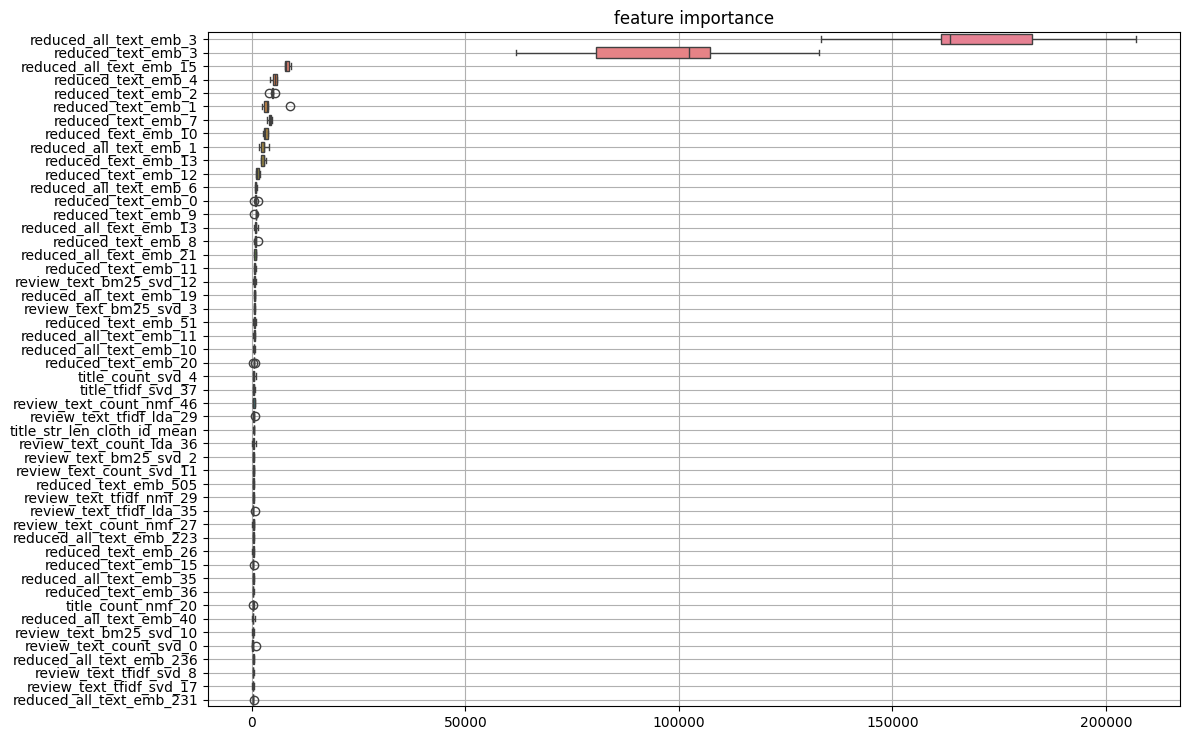

In [21]:
# 学習済みモデルから特徴量の重要度を取り出す
raw_importances = cvbooster_stage_1.feature_importance(importance_type="gain")
importance_df = pd.DataFrame(data=raw_importances, columns=cvbooster_stage_1.feature_name()[0])

# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロット -> 保存
plot_cols = sorted_importance_df.columns[:50]
fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
ax.grid()
ax.set_title("feature importance")
fig.tight_layout()
plt.show()
fig.savefig(f"{cfg.data.results_dir}/feature_importance_stage_1.png")


### oof(Stage1)

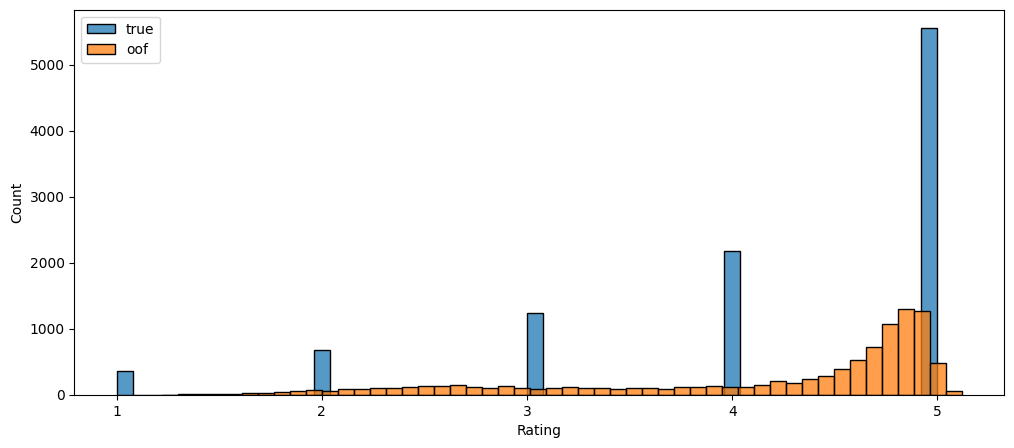

In [22]:
oof = np.zeros(len(x_train))

# 各fold毎に推論してoofを作成
for i, (_, valid_idx) in enumerate(skf.split(x_train, y_train)):
    x_valid = x_train.iloc[valid_idx]
    model = cvbooster_stage_1.boosters[i]
    y_pred = model.predict(x_valid, num_iteration=cvbooster_stage_1.best_iteration)
    oof[valid_idx] = y_pred

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof_stage_1.csv", index=False)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist_stage_1.png")


### prediction(Stage1)

In [27]:
# 推論
x_test = test_df.drop(["Title", "Review Text"]).to_pandas()
y_preds = cvbooster_stage_1.predict(x_test, num_iteration=cvbooster_stage_1.best_iteration)
y_pred = np.mean(y_preds, axis=0)

# test_dfにRatingを追加
test_df = test_df.with_columns(pl.Series(y_pred).alias("Rating"))



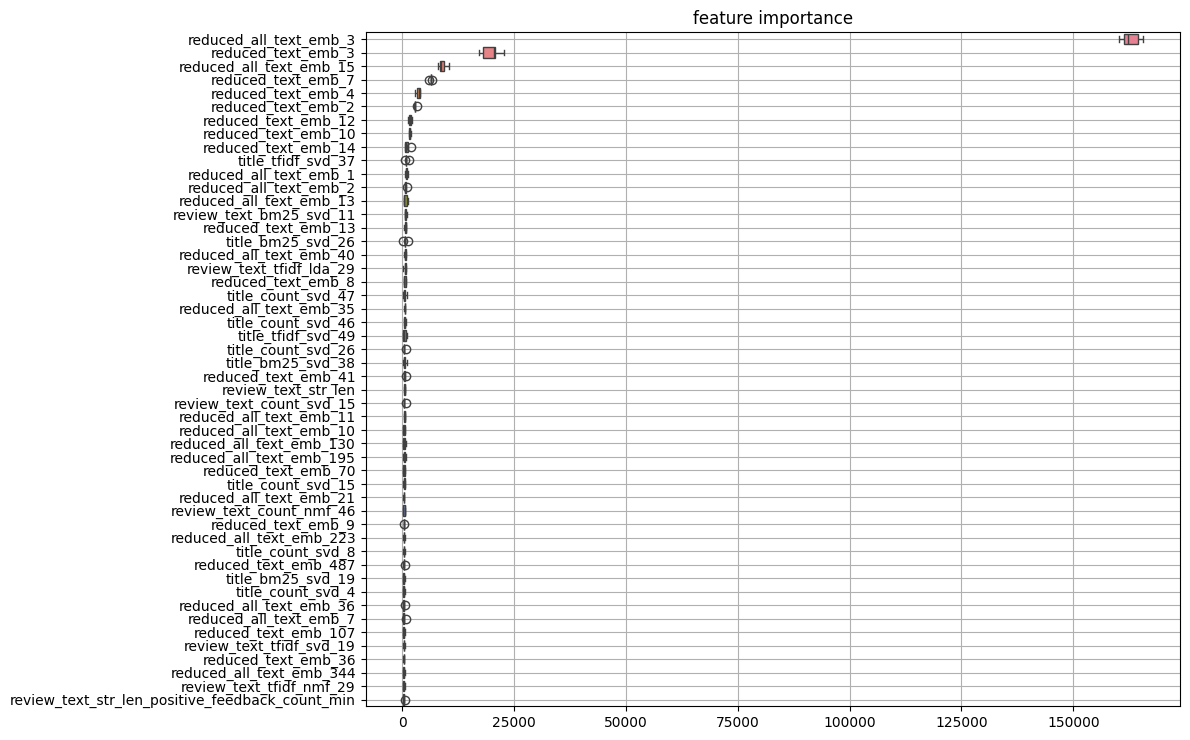

In [41]:
# 学習済みモデルから特徴量の重要度を取り出す
raw_importances = cvbooster.feature_importance(importance_type="gain")
importance_df = pd.DataFrame(data=raw_importances, columns=cvbooster.feature_name()[0])

# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロット -> 保存
plot_cols = sorted_importance_df.columns[:50]
fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
ax.grid()
ax.set_title("feature importance")
fig.tight_layout()
plt.show()
fig.savefig(f"{cfg.data.results_dir}/feature_importance.png")


### 学習(Stage2)

In [28]:
extract_features = [cfg.target, "Title", "Review Text"]
x_train = train_df.drop(extract_features).to_pandas()
y_train = train_df[cfg.target].to_pandas()

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

# 学習設定
lgb_data = lgb.Dataset(
    x_train,
    label=y_train,
    # categorical_feature=x_train.select_dtypes(include=["category"]).columns.tolist(),
    free_raw_data=True,
)
callbacks = [
    lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
    lgb.log_evaluation(cfg.lgb.log_evaluation),
]

# 学習
cv_results_stage_2 = lgb.cv(
    dict(cfg.lgb.params_stage2),
    lgb_data,
    folds=skf.split(x_train, y_train),
    num_boost_round=cfg.lgb.num_boost_round,
    callbacks=callbacks,
    return_cvbooster=True,
    stratified=False,
    seed=cfg.seed,
)

# 学習モデル保存
cvbooster_stage_2 = cv_results_stage_2["cvbooster"]
cvbooster_stage_2.save_model(f"{cfg.data.results_dir}/model_stage_2.pkl")


Training until validation scores don't improve for 500 rounds
[100]	cv_agg's valid auc: 0.981483 + 0.00301783
[200]	cv_agg's valid auc: 0.9817 + 0.00336627
[300]	cv_agg's valid auc: 0.98241 + 0.00314534
[400]	cv_agg's valid auc: 0.982561 + 0.00309093
[500]	cv_agg's valid auc: 0.982854 + 0.00288563
[600]	cv_agg's valid auc: 0.982758 + 0.00293973
[700]	cv_agg's valid auc: 0.982761 + 0.00282602
[800]	cv_agg's valid auc: 0.982748 + 0.00279045
[900]	cv_agg's valid auc: 0.982876 + 0.00279686
[1000]	cv_agg's valid auc: 0.982924 + 0.00271471
[1100]	cv_agg's valid auc: 0.982944 + 0.00273839
[1200]	cv_agg's valid auc: 0.982876 + 0.00267668
[1300]	cv_agg's valid auc: 0.982923 + 0.0026621
[1400]	cv_agg's valid auc: 0.982873 + 0.00267613
[1500]	cv_agg's valid auc: 0.982867 + 0.00265862
[1600]	cv_agg's valid auc: 0.982837 + 0.00266484
Early stopping, best iteration is:
[1103]	cv_agg's valid auc: 0.982951 + 0.00272524


### log(Stage2)

In [32]:
best_iteration = cvbooster_stage_2.best_iteration
best_score = cv_results_stage_2["valid auc-mean"][best_iteration - 1]
best_score_stdv = cv_results_stage_2["valid auc-stdv"][best_iteration - 1]

with open(f"{cfg.data.results_dir}/log_stage_2.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_iteration: {best_iteration}\n")
    log_file.write(f"best_score (auc): {best_score}\n")
    log_file.write(f"best_score_stdv (auc): {best_score_stdv}\n")

    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

    log_file.write("\n====== feature name ======\n")
    log_file.write(pprint.pformat(cvbooster_stage_2.feature_name()[0]))


### Feature Importance(Stage2)

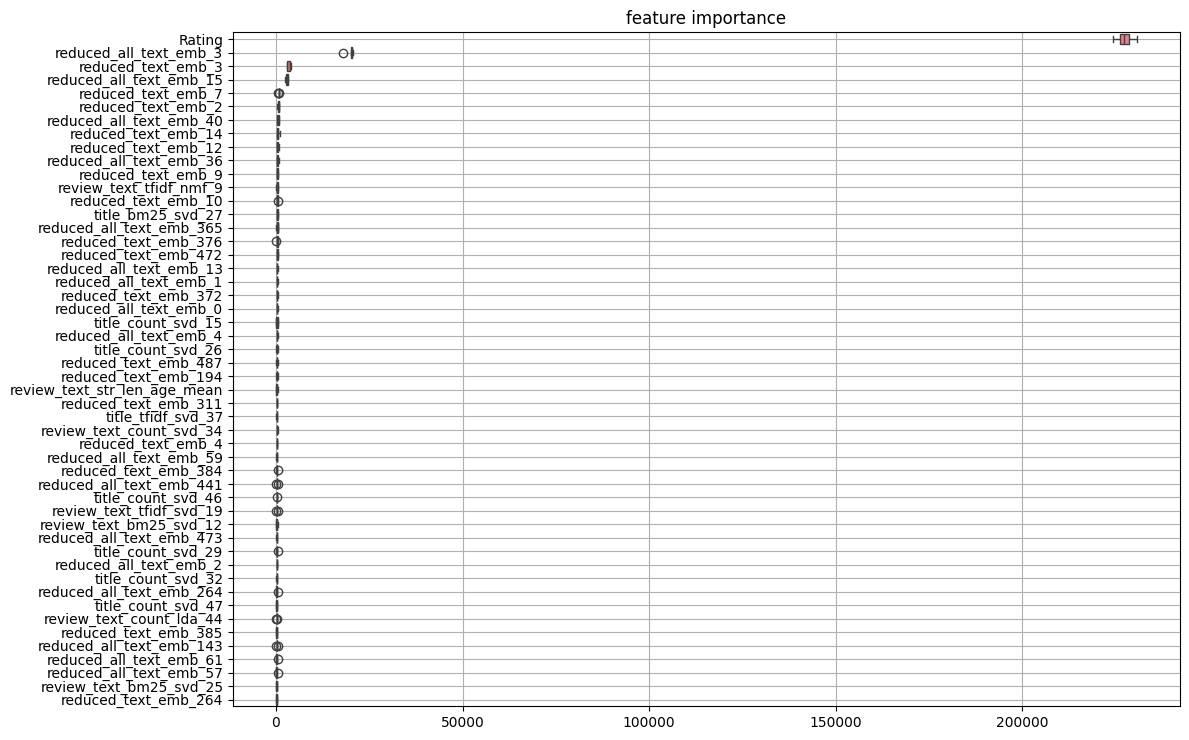

In [33]:
# 学習済みモデルから特徴量の重要度を取り出す
raw_importances = cvbooster_stage_2.feature_importance(importance_type="gain")
importance_df = pd.DataFrame(data=raw_importances, columns=cvbooster_stage_2.feature_name()[0])

# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロット -> 保存
plot_cols = sorted_importance_df.columns[:50]
fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
ax.grid()
ax.set_title("feature importance")
fig.tight_layout()
plt.show()
fig.savefig(f"{cfg.data.results_dir}/feature_importance_stage_2.png")


### oof(Stage2)

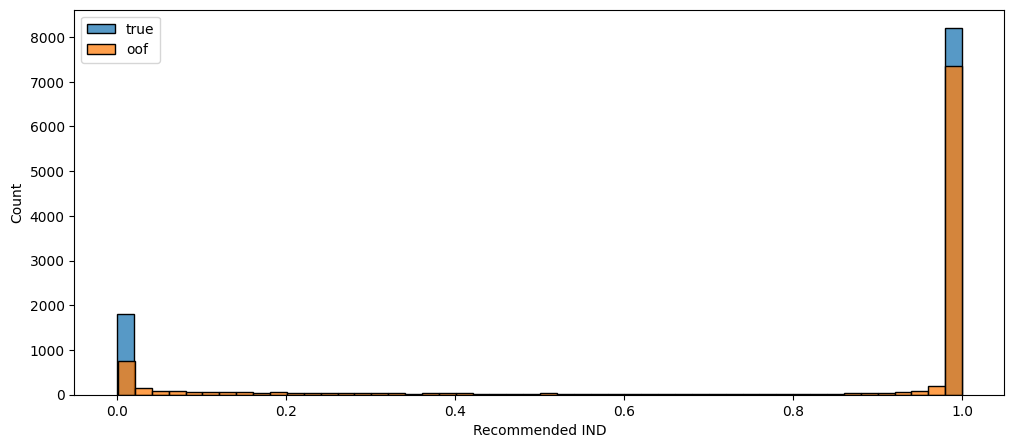

In [34]:
oof = np.zeros(len(x_train))

# 各fold毎に推論してoofを作成
for i, (_, valid_idx) in enumerate(skf.split(x_train, y_train)):
    x_valid = x_train.iloc[valid_idx]
    model = cvbooster_stage_2.boosters[i]
    y_pred = model.predict(x_valid, num_iteration=cvbooster_stage_2.best_iteration)
    oof[valid_idx] = y_pred

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof_stage_2.csv", index=False)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist_stage_2.png")


### Submission

In [35]:
# 推論
x_test = test_df.drop(["Title", "Review Text"]).to_pandas()
y_preds = cvbooster_stage_2.predict(x_test, num_iteration=cvbooster_stage_2.best_iteration)
y_pred = np.mean(y_preds, axis=0)

# 提出用ファイル作成
sub_df = pd.read_csv(cfg.data.sample_submission_path)
sub_df["target"] = y_pred
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
sub_df.head()


,target
0,0.106565
1,0.031274
2,0.064912
3,0.979841
4,0.044767


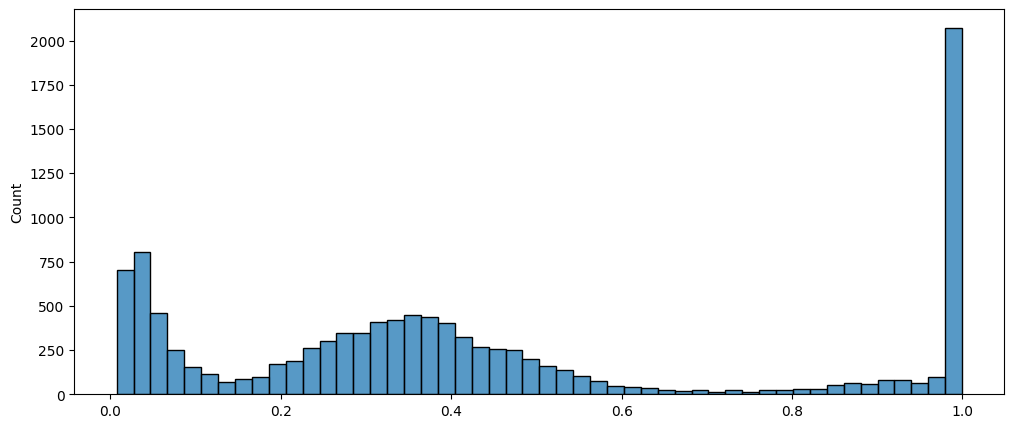

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_pred, bins=50)
plt.show()
